# LWA1 Source Maps

Maps -- Filenames


lwa1_80mhz_map -- "lwa1_80mhz_map.fits"

lwa1_80mhz_noisemap -- "lwa1_80mhz_noisemap.fits"

lwa1_80mhz_maskmap -- "lwa1_80mhz_maskmap.fits"

lwa1_80mhz_beamcls -- "lwa1_80mhz_beam.fits"



NOTE:

lwa1 fits files are in equatorial coordinates.




Need:

param file
default file defining details about map
job submission file

telescope details:


declination, resolution, scan strategy, mapmaking

LWA1 

Sky maps released by the LWA1 group are in HEALPix sky pixelization for equatorial coordinates with an approximate pixel size of 0.23 degrees and in equatorial Mollweide projection with an approximate pixel size of 0.3 degrees.

Sources of uncertainties/errors: (Lukas email)

- temperature scale error
- Confusion limit ---> do not include in rms map


10-NOV-22 Meeting 


FOR LWA1 noise:
    look at output chi2 from comm --> reduced chi2 should be close to 1 (not 0.001 or 1000)
    data - signal model / standard deviation


LATEST LWA1 run:
    num chains              = 1
    num gibbs iterations    = 200

    sample amplitude        = true
    sample spectral indices = true

    gain sampling           = false

    bands                   =   (1) haslam 
                                (2) 80lwa1
    
    comps                   =   (1) synch 
                                (2) md 
                                (3) ff

In [16]:
import glob
from cmath import nan

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.titlesize'] = 12
# mpl.rcParams['axes.titlesize'] = 12
# mpl.rcParams['font.size'] = 8
mpl.rcParams['figure.dpi'] = 300

from datetime import datetime
now = datetime.now()
# plt.rcParams['savefig.facecolor']='white'

from pathlib import Path
maps_dir_path = Path("../map-images/")

import h5py as h5

## Create LWA1 maps for Commander input

In [17]:
def change_coord(m, coord):
    """Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

lwa1 map size:
 786432
no. of nan pixels (to be masked):
 140798
(1) no. of pixels <= 0:
 0
(2) no. of pixels <= 0:
 0


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


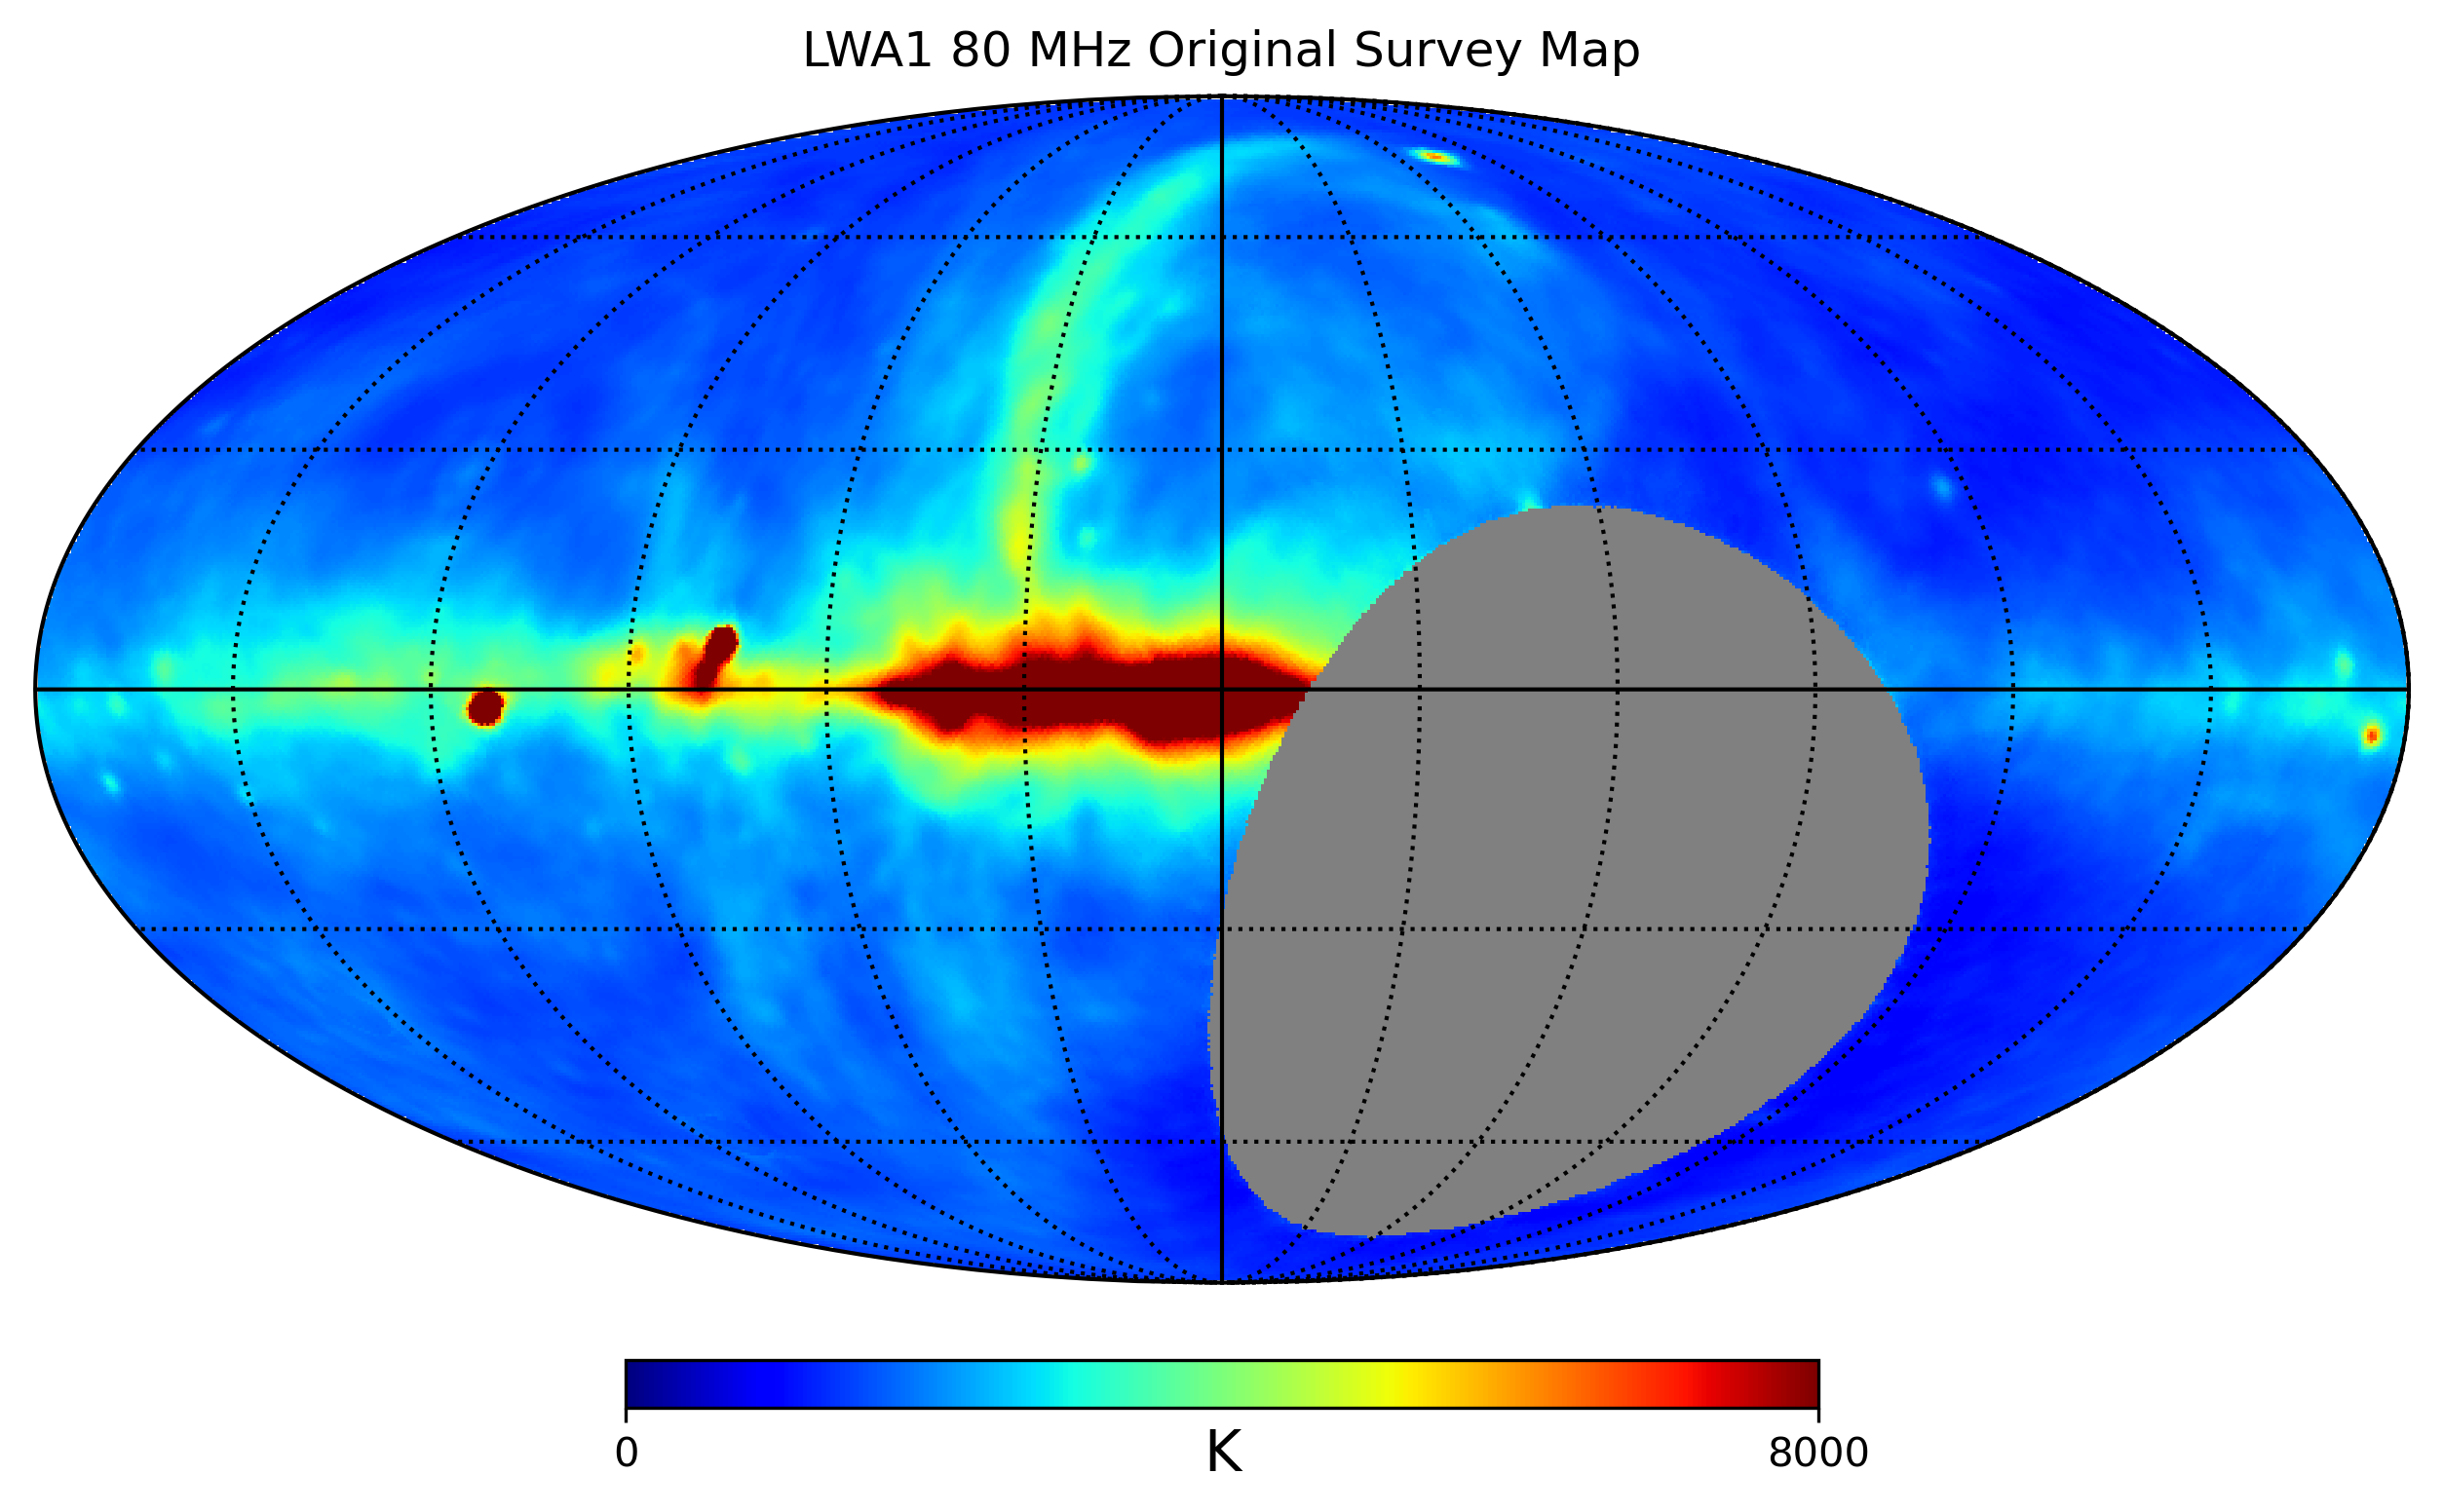

In [5]:
file_lwa180 = "lwa1-source_fits/healpix-all-sky-rav-wsclean-map-80.fits"
celest_lwa180 = hp.fitsfunc.read_map(file_lwa180, dtype=None)

###############################
# Random stuff I was trying
###############################
# hp.fitsfunc.write_map("healpix-galactic_coord_map-80.fits", celest_lwa180, coord='G', overwrite=True, dtype=None)
# file_G_lwa180 = "healpix-galactic_coord_map-80.fits"
# map_lwa180 = hp.fitsfunc.read_map(file_G_lwa180)
# rot_cg = hp.Rotator(coord="CG")
# map_lwa180 = rot_cg.rotate_map_pixel(celest_lwa180)
###############################

#
# Change coordinates from equatorial to galactic/celestial
#
lwa1_80mhz_map = change_coord(celest_lwa180, ['C', 'G'])
test_lwa180 = np.copy(lwa1_80mhz_map)
print("lwa1 map size:\n", lwa1_80mhz_map.size)

###############################
# 
# Doing these checks for bad pixels, aka pixel values <= 0.
# 
###############################
# Find the nan-valued pixels
idx_mask_sig = np.argwhere(np.isnan(lwa1_80mhz_map))
print("no. of nan pixels (to be masked):\n", idx_mask_sig.size)
# print("indices for nan pixels (to be masked):\n", idx_mask_sig)

# Find the <=0 pixels:
idx_badpix_sig = np.where(lwa1_80mhz_map <= 0) 
# The above is a tuple with at least 1 element, i.e. an empty array.
# So to check the size of the array contained by the tuple, I need to extract the array (as below)
idx_badpix_sig = idx_badpix_sig[0]
print("(1) no. of pixels <= 0:\n", idx_badpix_sig.size)
print("(2) no. of pixels <= 0:\n", (lwa1_80mhz_map <= 0).sum()) # This is another way to check for pixels valued <=0
# print("indices of pixels <= 0:\n", idx_badpix_sig)

# 
# if there are pixels <=0, we could set them to 'nan' as:
# lwa1_80mhz_map[idx_badpix_sig] = nan
# 

###############################
# 
# So far, there are no pixels <= 0, but there are quite a few that are nan-valued.
# I believe these are just the ones that are already greyed out (and therefore will be masked).
#
###############################

#
# Display the map to check if it's okay
#
hp.mollview(lwa1_80mhz_map, title="LWA1 80 MHz Original Survey Map", min=0.0, max=8000.0, cmap='jet', unit='K')
hp.graticule()
# hp.mollview(celest_lwa180/1000, min=0.9, max=4.5, coord=['C', 'G'], cmap='gist_heat', unit='kK')
# hp.mollview(map_lwa180/1000, min=0.9, max=4.5, coord=['C', 'G'], cmap='gist_heat')
# hp.mollview(map_lwa180, coord=['C', 'G'])
# hp.mollview(map_lwa180,  coord=['C', 'G'], norm="hist")

#
# Save the map as a fits file with the right name etc.
#
hp.fitsfunc.write_map("commander_inputs/lwa1_80mhz_map.fits", lwa1_80mhz_map, overwrite=True, dtype=None)

# 
# Save the map as a png image
# 
plt.savefig(maps_dir_path/'lwa1_80mhz_map.png')



In [6]:
file_noise_C_lwa180 = "healpix-all-sky-rav-wsclean-err-80.fits"
noise_C_lwa180 = hp.fitsfunc.read_map(file_noise_C_lwa180, dtype=None)
lwa1_80mhz_noisemap = change_coord(noise_C_lwa180, ['C', 'G'])

###############################
# 
# Doing these checks for bad pixels, aka pixel values <= 0.
# 
###############################
print("\nBEFORE NAN-ing bad-pixels:")
#
# Find the nan-valued pixels
#
idx_mask_noise = np.argwhere(np.isnan(lwa1_80mhz_noisemap))
print("no. of nan pixels (to be masked):\n", idx_mask_noise.size)
# print("indices for nan pixels (to be masked):\n", idx_mask_noise)

#
# Find the <=0 pixels:
#
idx_badpix_noise = np.where(lwa1_80mhz_noisemap <= 0)
# The above is a tuple with at least 1 element, i.e. an empty array.
# So to check the size of the array contained by the tuple, I need to extract the array (as below)
idx_badpix_noise = idx_badpix_noise[0]
print("(1) no. of pixels <= 0:\n", idx_badpix_noise.size)
print("(2) no. of pixels <= 0:\n", (lwa1_80mhz_noisemap <= 0).sum()) # This is another way to check for pixels valued <=0
# print("indices of pixels <= 0:\n", idx_badpix_noise)

#
# if there are pixels <=0 (and there are quite a few!), we set them to 'nan' as: 
#
print(lwa1_80mhz_noisemap[idx_badpix_noise])
lwa1_80mhz_noisemap[idx_badpix_noise] = nan

#
# Now check again to see if there are any bad pixels left...
#
idx_badpix_noise = np.where(lwa1_80mhz_noisemap <= 2)[0]
print("\nAFTER NAN-ing bad pixels:")
print("(1) no. of pixels <= 0:\n", idx_badpix_noise.size)
print("(2) no. of pixels <= 0:\n", (lwa1_80mhz_noisemap <= 0).sum()) # This is another way to check for pixels valued <=0
# print("indices of pixels <= 0:\n", idx_badpix_noise)

# 
# Now we update our array of indices for nan-pixels
# 
idx_mask_noise = np.argwhere(np.isnan(lwa1_80mhz_noisemap))
print("no. of nan pixels (to be masked):\n", idx_mask_noise.size)

# print(lwa1_80mhz_noisemap[idx_badpix_noise])

###############################
# 
# So far, there are ???
#
###############################


print(np.mean(np.delete(lwa1_80mhz_noisemap, idx_mask_noise)))
print(np.mean(lwa1_80mhz_noisemap))

# lwa1_80mhz_noisemap[:] = np.mean(np.delete(lwa1_80mhz_noisemap, idx_mask_noise))



#
# Display the noise map to check if it's okay
#
hp.mollview(lwa1_80mhz_noisemap, title="LWA1 80 MHz Noise Map", min=0.0, max=700, cmap='gist_heat', unit='K')
# Save the map as a fits file with the right name etc.

hp.fitsfunc.write_map("commander_inputs/lwa1_80mhz_noisemap.fits", lwa1_80mhz_noisemap, overwrite=True, dtype=None)

#
# Create PERCENT-NOISE map from the noise map
#
percentnoise_lwa180 = lwa1_80mhz_noisemap/lwa1_80mhz_map * 100
#
# Display the percent-noise map to check if it's okay
#
hp.mollview(percentnoise_lwa180, title="LWA1 80 MHz Percent Noise Map", min=0.0, max=30.0, cmap='gist_heat', unit='Percent Error')

# 
# Save both the noise maps as a png images
# 
plt.savefig(maps_dir_path/'lwa1_80mhz_noisemap.png')
plt.savefig(maps_dir_path/'percentnoise_lwa180.png')


# print(lwa1_80mhz_noisemap.min())

FileNotFoundError: [Errno 2] No such file or directory: 'healpix-all-sky-rav-wsclean-err-80.fits'

The noise mask is bigger than the intensity map mask (i.e. the intensity mask is a SUBSET of the noise mask), so probably better to create the mask map using the noise map.

In [ ]:
print(idx_mask_sig.size, idx_mask_noise.size)
# Check if there are any mask-pix in the intensity map that are not in the noise map
sigdiffnoise = np.setdiff1d(idx_mask_sig, idx_mask_noise)
print(sigdiffnoise.size)
# Check if there are any mask-pix in the noise map that are not in the intensity map
noisediffsig = np.setdiff1d(idx_mask_noise, idx_mask_sig)
print(noisediffsig.size)
# np.where(idx_mask_sig != idx_mask_noise)



#
# So the mask we'll use is the noise map mask:
#
lwa1_80mhz_map[noisediffsig] = nan
idx_mask = idx_mask_noise

#
# Save the map as a fits file with the right name etc.
#
hp.fitsfunc.write_map("commander_inputs/lwa1_80mhz_map.fits", lwa1_80mhz_map, overwrite=True, dtype=None)

140798 140965
0
167


In [ ]:
goodmask_sig = hp.mask_good(lwa1_80mhz_map)
goodmask_noise = hp.mask_good(lwa1_80mhz_noisemap)
idxnmask = np.where(goodmask_noise==False)[0]
idxsmask = np.where(goodmask_sig==False)[0]
print(idxnmask.size)
print(idxsmask.size)
lwa1_80mhz_maskmap_small = goodmask_sig.astype(int)
lwa1_80mhz_maskmap_big = goodmask_noise.astype(int)
# lwa1_80mhz_maskmap[idx_badpix_noise] = 0

hp.fitsfunc.write_map("commander_inputs/lwa1_80mhz_maskmap.fits", lwa1_80mhz_maskmap_big, overwrite=True, dtype=None)

# hp.mollview(lwa1_80mhz_maskmap)

140965
140965


range(0, 819)


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/fitsfunc.py:99: FutureWarning: The default dtype of write_cl() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


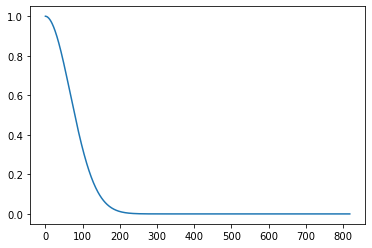

In [ ]:
# 
# find fwhm: beamsize*2*pi/180
# lmax: nside*3 - 1 (but add some here)
# compute blms using healpy.spherfunc.gauss_beam with fwhm and lmax as input
# healpy write cls to fits file
# 

beamsize = 2.0
fwhm = 2.0*np.pi/180
nside = 256
lmax = nside * 3 + 50
lwa1_80mhz_beamcls = hp.sphtfunc.gauss_beam(fwhm=fwhm, lmax=lmax)

hp.fitsfunc.write_cl(filename='commander_inputs/lwa1_80mhz_beam.fits', cl=lwa1_80mhz_beamcls, overwrite=True, dtype=None)

x = range(lwa1_80mhz_beamcls.size)
print(x)
plt.plot(x, lwa1_80mhz_beamcls)

/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


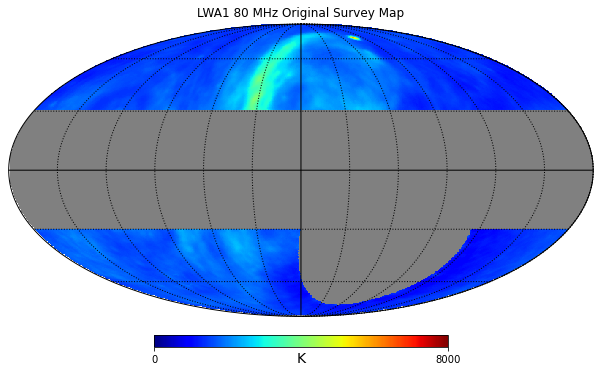

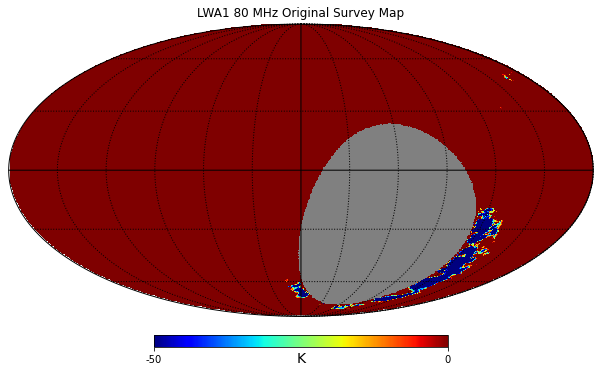

In [ ]:
# min = 0.0
# max = 8000.0
min = -50.0
max = 0.0
gcut = 30.0

###############################
thetadiff = np.radians(gcut)
theta1 = np.pi/2 - thetadiff
theta2 = np.pi/2 + thetadiff
ipix_strip = hp.query_strip(nside=256, theta1=theta1, theta2=theta2, inclusive=True)
test_lwa180[ipix_strip] = nan

hp.mollview(test_lwa180, title="LWA1 80 MHz Original Survey Map", min=0.0, max=8000.0, cmap='jet', unit='K')
hp.graticule()
###############################

hp.mollview(lwa1_80mhz_map-1120, title="LWA1 80 MHz Original Survey Map", min=min, max=max, cmap='jet', unit='K')
hp.graticule()

Monopole from Dowell & Taylor, 2018

In [ ]:
# Extract monopole/dipole from the map
gcut = 0.0
md_80mlwa1 = hp.fit_dipole(lwa1_80mhz_map,  gal_cut=gcut)
mp_80mlwa1 = hp.fit_monopole(lwa1_80mhz_map, gal_cut=gcut)

print(md_80mlwa1)
print(mp_80mlwa1)

(2214.003599620877, array([893.18359529, 507.1652158 , -16.81614988]))
2203.1161376181894


In [ ]:
# Extract monopole/dipole from the map
gcut = 0.0
gcut = 15.0
gcut = 30.0
md_80mlwa1 = hp.fit_dipole(lwa1_80mhz_map,  gal_cut=gcut)
mp_80mlwa1 = hp.fit_monopole(lwa1_80mhz_map, gal_cut=gcut)

print(md_80mlwa1)
print(mp_80mlwa1)

(1682.699311681605, array([499.21685021, 263.0523565 ,  90.3583111 ]))
1689.2455727097708


/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 1682.7  dipole: lon: 27.7861, lat: 9.09753, amp: 571.471
  warnings.warn(
/astro/local/anaconda/envs/py38/lib/python3.8/site-packages/healpy/pixelfunc.py:1691: UserWarning: monopole: 1689.25
  warnings.warn("monopole: {0:g}".format(mono))


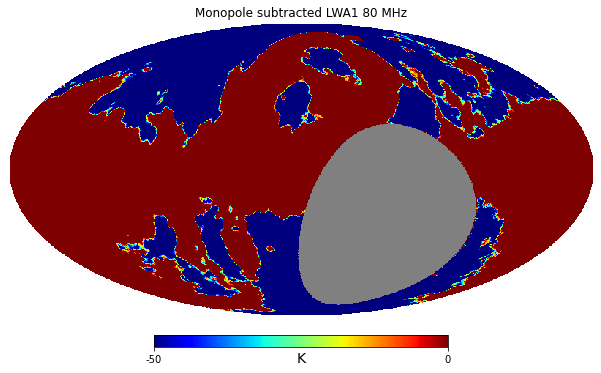

In [ ]:
mdsub_80mlwa1 = hp.remove_dipole(lwa1_80mhz_map, gal_cut=gcut, bad=nan)
mpsub_80mlwa1 = hp.remove_monopole(lwa1_80mhz_map, gal_cut=gcut, bad=nan)

# min = 0.0
# max = 8000.0
min = -50.0
max = 0.0
hp.mollview(mdsub_80mlwa1, title="Monopole subtracted LWA1 80 MHz", min=min, max=max, cmap='jet', unit='K')
# hp.mollview(mpsub_80mlwa1, title="LWA1 80 MHz Original Survey Map", cmap='jet', unit='K')
